In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from numpy import sqrt
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
series=pd.read_csv('/water.csv', header=0, index_col=0, parse_dates=True)

In [3]:
series

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413
...,...
1959-01-01,594
1960-01-01,587
1961-01-01,587


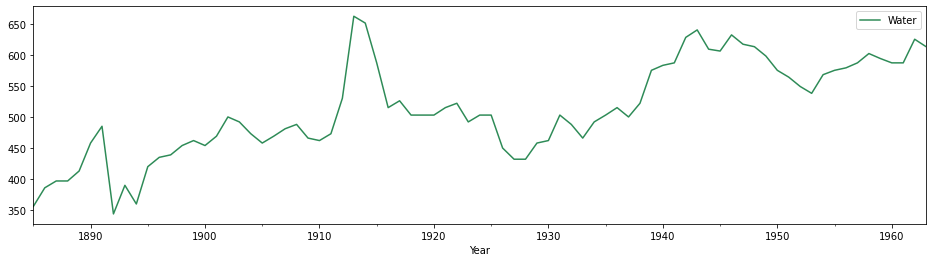

In [4]:
# line plot of time series
series.plot(color="seagreen",figsize=(16,4));

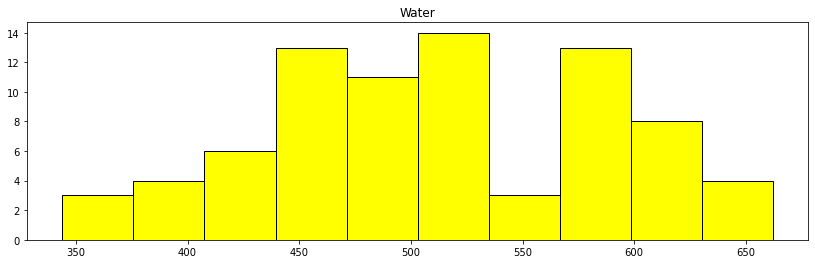

In [5]:
series.hist(grid=False,facecolor ="yellow",edgecolor ="black",figsize=(14,4));

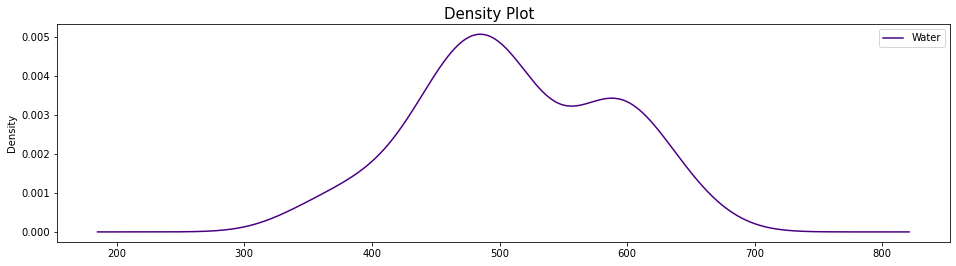

In [6]:
series.plot(kind='kde',color="indigo",figsize=(16,4))
plt.suptitle('Density Plot', size=15, y=0.94)
plt.show();

In [7]:
# separate out a validation dataset
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 69, Validation 10


#### Persistence/ Base model

In [8]:
# evaluate a persistence model
# load data
train =pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [9]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=522.000
>Predicted=522.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=450.000
>Predicted=450.000, Expected=432.000
>Predicted=432.000, Expected=432.000
>Predicted=432.000, Expected=458.000
>Predicted=458.000, Expected=462.000
>Predicted=462.000, Expected=503.000
>Predicted=503.000, Expected=488.000
>Predicted=488.000, Expected=466.000
>Predicted=466.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=500.000
>Predicted=500.000, Expected=522.000
>Predicted=522.000, Expected=575.000
>Predicted=575.000, Expected=583.000
>Predicted=583.000, Expected=587.000
>Predicted=587.000, Expected=628.000
>Predicted=628.000, Expected=640.000
>Predicted=640.000, Expected=609.000
>Predicted=609.000, Expected=606.000
>

#### ARIMA Hyperparameters

In [10]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

#### Grid search for p,d,q values

In [11]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [12]:
# load dataset
train =pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=76.755
ARIMA(0, 0, 1) RMSE=47.346
ARIMA(0, 0, 2) RMSE=36.048
ARIMA(0, 0, 3) RMSE=32.587
ARIMA(0, 1, 0) RMSE=22.311
ARIMA(0, 1, 1) RMSE=22.258
ARIMA(0, 1, 2) RMSE=28.430
ARIMA(0, 1, 3) RMSE=30.054
ARIMA(0, 2, 0) RMSE=29.335
ARIMA(0, 2, 1) RMSE=23.072
ARIMA(0, 2, 2) RMSE=22.954
ARIMA(0, 2, 3) RMSE=23.375
ARIMA(1, 0, 0) RMSE=23.958
ARIMA(1, 0, 1) RMSE=23.998
ARIMA(1, 0, 2) RMSE=25.412
ARIMA(1, 0, 3) RMSE=31.454
ARIMA(1, 1, 0) RMSE=22.270
ARIMA(1, 2, 0) RMSE=27.786
ARIMA(1, 2, 1) RMSE=22.979
ARIMA(2, 0, 0) RMSE=24.131
ARIMA(2, 0, 1) RMSE=24.140
ARIMA(2, 1, 0) RMSE=22.084
ARIMA(2, 2, 0) RMSE=25.616
ARIMA(2, 2, 3) RMSE=25.607
ARIMA(3, 0, 0) RMSE=24.183
ARIMA(3, 0, 1) RMSE=24.967
ARIMA(3, 1, 0) RMSE=25.060
ARIMA(3, 1, 1) RMSE=32.092
ARIMA(3, 2, 0) RMSE=26.126
ARIMA(3, 2, 1) RMSE=25.593
Best ARIMA(2, 1, 0) RMSE=22.084


#### Build Model based on the optimized values

In [13]:
# load data
train =pd.read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

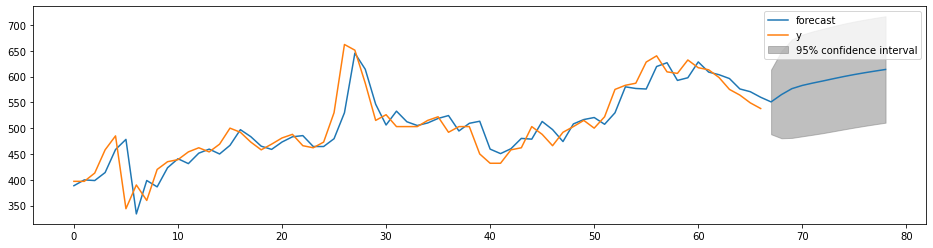

In [14]:
# fit model
model = ARIMA(X, order=(4,1,1))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
fig, ax = plt.subplots(figsize=(16,4))
model_fit.plot_predict(1, 79,ax=ax);

In [15]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

11.710517005623297

#### Combine train and test data and build final model

In [16]:
# fit model
data =pd.read_csv('/water.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [17]:
model = ARIMA(X, order=(4,1,1))
model_fit = model.fit()

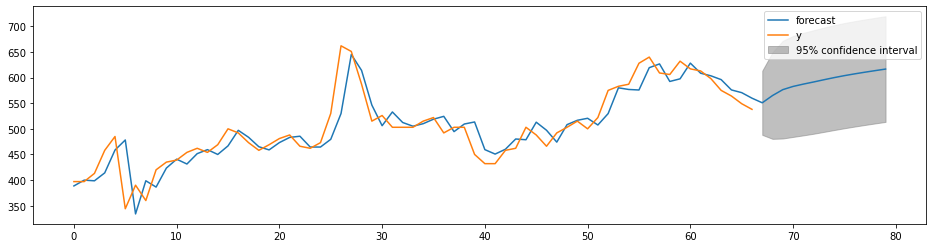

In [18]:
forecast=model_fit.forecast(steps=10)[0]
fig, ax = plt.subplots(figsize=(16,4))
model_fit.plot_predict(1,80,ax=ax);

In [19]:
pd.DataFrame(forecast)

,0
0,550.809753
1,564.957206
2,576.467572
3,582.723446
4,587.273111
5,591.416517
6,595.774920
7,599.959726
8,603.806464
9,607.288400
